In [61]:
def newplotspace(filename1,filename2,datastart,types,types2):
    # import basic packages and earth magnetic model
    import scipy.signal.windows as spsw
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline
    import re
    import chaosmagpy as cp
    from chaosmagpy.model_utils import synth_values
    from chaosmagpy.data_utils import mjd2000
    from chaosmagpy.plot_utils import plot_timeseries
    model = cp.load_CHAOS_matfile('CHAOS-6-x9.mat')
    possible_characters = ('-', ' ')
    path='/usr/people/out/Documents/Magnetic_field/'
    
##### calculate values from observation station #####
    # read-in file of station
    File=open(f'{path}{filename2}','r') # open file
    counter=0
    HorX=[] # make some lists
    DeclY=[]
    VertZ=[]
    X2=[]
    N=0
    for line in File:
        if counter==2:
            words=line.split()
            station=words[2]
        if counter==4:
            words=line.split()
            lat=float(words[2]) # latitude station
        if counter==5:
            words=line.split()
            lon=float(words[2]) # longitude station
        if counter>=datastart-1: #read when the data starts
            N+=1
            if counter==datastart-1:
                dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date
                
            words=line.split()
            HorX.append(float(words[3])) # get horizontal or X-component
            DeclY.append(float(words[4])) # get 'declination' or Y-component
            VertZ.append(float(words[5])) # get vertical component or Z-component
        counter+=1
    File.close()
    
    if types and types2: #if given in XYZ, types==true
        X2=HorX
        Y2=DeclY
        Z2=VertZ
            
    if types==False and types2: #if given in HDZ, types==false in degrees!
        t=HorX
        HorX=DeclY
        DeclY=t
        Y2=[]
        for item in range(len(DeclY)):
            DeclY[item]=(DeclY[item]+360)%360
            X2.append(HorX[item]*np.cos(np.radians(DeclY[item]/60))) #minus is added to immediately transform to polar coordinates
            Y2.append(HorX[item]*np.sin(np.radians(DeclY[item]/60)))
        Z2=VertZ
        
    if types==False and types2==False: #if given in HDZ, types==false
        t=HorX
        print(t)
        print(HorX)
        HorX=DeclY
        print(DeclY)
        print(HorX)
        DeclY=t
        for item in range(len(DeclY)):
            X2.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
        Y2=DeclY
        Z2=VertZ
    
    File=open(f'{path}{filename1}','r') # open file
    counter=0
    HorX=[] # make some lists
    DeclY=[]
    VertZ=[]
    X1=[]
    N=0
    for line in File:
        if counter==2:
            words=line.split()
            station=words[2]
        if counter==4:
            words=line.split()
            lat=float(words[2]) # latitude station
        if counter==5:
            words=line.split()
            lon=float(words[2]) # longitude station
        if counter>=datastart-1: #read when the data starts
            N+=1
            if counter==datastart-1:
                dates=re.split("[%s]" % ("".join(possible_characters)), line) # get start date
                
            words=line.split()
            HorX.append(float(words[3])) # get horizontal or X-component
            DeclY.append(float(words[4])) # get 'declination' or Y-component
            VertZ.append(float(words[5])) # get vertical component or Z-component
        counter+=1
    File.close()
    try:
        os.mkdir(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}')
    except Exception:
        pass
    
    if types and types2: #if given in XYZ, types==true
        X1=HorX
        Y1=DeclY
        Z1=VertZ
            
    if types==False and types2: #if given in HDZ, types==false
        t=HorX
        HorX=DeclY
        DeclY=t
        Y1=[]
        for item in range(len(DeclY)):
            DeclY[item]=(DeclY[item]+360)%360
            X1.append(HorX[item]*np.cos(np.radians(DeclY[item]/60))) #minus is added to immediately transform to polar coordinates
            Y1.append(HorX[item]*np.sin(np.radians(DeclY[item]/60)))
        Z1=VertZ

    if types==False and types2==False: #if given in HDZ, types==false
        t=HorX
        HorX=DeclY
        DeclY=t
        for item in range(len(DeclY)):
            X1.append(np.sqrt(HorX[item]**2-DeclY[item]**2)) #minus is added to immediately transform to polar coordinates
        Y1=DeclY
        Z1=VertZ
##### calculate model value of magnetic field #####
    # set up

    secormin='hour'

    if int(dates[2])==31:
        if int(dates[1])==12:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                               mjd2000(int(dates[0])+1,1,1), num=N)
        else:
            time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])), 
                               mjd2000(int(dates[0]),int(dates[1])+1,1), num=N)
    else:
        time = np.linspace(mjd2000(int(dates[0]),int(dates[1]),int(dates[2])),
                           mjd2000(int(dates[0]),int(dates[1]),int(dates[2])+1), num=N)
    
##### subtract the two data sets! #####
    SpaceX=np.subtract(X1,X2)
    SpaceY=np.subtract(Y1,Y2)
    SpaceZ=np.subtract(Z1,Z2)
        
##### plot data #####
    figx=plt.figure(figsize=(20,10))
    ax1=figx.add_subplot(311)
    ax11=figx.add_subplot(312)
    ax12=figx.add_subplot(313)
    ax1.set_title('$B_\\theta$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax12.set_xlabel('time (days after 1 jan 2000)')
    ax11.set_ylabel('$B_\\theta$ (nt)')
    ax11.plot(time,X1,label='observed',color='blue')
    ax12.plot(time,X2,label='model',color='green')
    ax1.plot(time,SpaceX,label='residue',color='red')
    ax1.legend()
    ax11.legend()
    ax12.legend()

    figy=plt.figure(figsize=(20,10))
    ax2=figy.add_subplot(311)
    ax21=figy.add_subplot(312)
    ax22=figy.add_subplot(313)
    ax2.set_title('$B_\\phi$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax22.set_xlabel('time (days after 1 jan 2000)')
    ax21.set_ylabel('$B_\\phi$ (nt)')
    ax21.plot(time,Y1,label='total',color='blue')
    ax22.plot(time,Y2,label='model',color='green')
    ax2.plot(time,SpaceY,label='residue',color='red')
    ax2.legend()
    ax21.legend()
    ax22.legend()

    figz=plt.figure(figsize=(20,10))
    ax3=figz.add_subplot(311)
    ax31=figz.add_subplot(312)
    ax32=figz.add_subplot(313)
    ax3.set_title('$B_r$ at '+ station + ' on ' + dates[0] + '-' + dates[1] + '-' + dates[2])
    ax32.set_xlabel('time (days after 1 jan 2000)')
    ax31.set_ylabel('$B_r$ (nt)')
    ax31.plot(time,Z1,label='total',color='blue')
    ax32.plot(time,Z2,label='model',color='green')
    ax3.plot(time,SpaceZ,label='residue',color='red')
    ax3.legend()
    ax31.legend()
    ax32.legend()
    plt.show()
    
    figall=plt.figure(figsize=(20,10))
    ax4=figall.add_subplot(311)
    ax41=figall.add_subplot(312)
    ax42=figall.add_subplot(313)
    ax4.set_title('Radial component')
    ax41.set_title('Longitudinal component')
    ax41.set_ylabel('nanoteslas')
    ax42.set_title('Latitudional component')
    ax4.plot(time,SpaceZ,color='red')
    ax41.plot(time,SpaceY,color='red')
    ax42.plot(time,SpaceX,color='red')
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/SWresult.png')
    
##### calculate frequency spectrum #####
    # try to get time derivative and frequency at which this happens, only horizontal components matter
    dXdt=np.zeros(len(SpaceX)) # define length array
    dYdt=np.zeros(len(SpaceY))

    for item in range(len(SpaceX)-1): # obtain derivative
        dXdt[item]=SpaceX[item+1]-SpaceX[item]
        dYdt[item]=SpaceY[item+1]-SpaceY[item]

    figx=plt.figure()
    ax1=figx.add_subplot()
    ax1.set_title('d$B_X$/dt at ' + station)
    ax1.set_xlabel('time (days after 1 jan 2000)')
    ax1.set_ylabel(f'd$B_X$/dt (nt/{secormin})')
    ax1.plot(time,dXdt,label='residue',color='red')
    ax1.legend()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtX.png')

    figy=plt.figure()
    ax2=figy.add_subplot()
    ax2.set_title('d$B_Y$/dt at ' + station)
    ax2.set_xlabel('time (days after 1 jan 2000)')
    ax2.set_ylabel(f'd$B_Y$/dt (nt/{secormin})')
    ax2.plot(time,dYdt,label='residue',color='red')
    ax2.legend()
#     plt.show()
    plt.savefig(f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/db\dtY.png')
    
    # get frequencyplot
    dXdt2=dXdt*spsw.hann(N)
    dYdt2=dYdt*spsw.hann(N)
    FdXshift=np.fft.fft(dXdt2) # get frequency component
    FdX=np.abs(np.fft.fftshift(FdXshift)) # shift it to the middle of the plot
    FdYshift=np.fft.fft(dYdt2) # get frequency component
    FdY=np.abs(np.fft.fftshift(FdYshift)) # shift it to the middle of the plot
    
#     if minsec:
#         Nu_c=1./(2.*1/60) # Nyquist frequency (1/min)
#         df=60./N #frequencystepping
#     else:
#         Nu_c=1./(2*1.)
#         df=1./N
#     freq=np.arange(-Nu_c,Nu_c,df)
#     # freq=np.fft.fftfreq(len(dXdt),60)
#     figfx=plt.figure()
#     ax1=figfx.add_subplot()
#     ax1.set_title('frequencyplot at ' + station)
#     ax1.set_xlabel('frequency X (1/min)')
#     ax1.set_xlim(-0.5,0.5)
#     ax1.set_ylabel('Amplitude')
#     ax1.plot(freq,FdX,label='residue',color='red')
#     ax1.legend()
#     plt.savefig(f'{path}station_results/new_{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyX.png')
#     figfy=plt.figure()
#     ax2=figfy.add_subplot()
#     ax2.set_title('frequencyplot at ' + station)
#     ax2.set_xlabel('frequency Y (1/min)')
#     ax2.set_xlim(-0.5,0.5)
#     ax2.set_ylabel('Amplitude')
#     ax2.plot(freq,FdY,label='residue',color='red')
#     ax2.legend()
# #     plt.show()
#     plt.savefig(f'{path}station_results/new_{station}_{dates[0]}-{dates[1]}-{dates[2]}/frequencyY.png')
    
    ### horizontal component ###
    Hor_comp=np.sqrt(SpaceX**2+SpaceY**2)
    dHdt=np.zeros(len(Hor_comp))
    for item in range(len(Hor_comp)-1): # obtain derivative
        dHdt[item]=Hor_comp[item+1]-Hor_comp[item]
#     dHdt2=dHdt*spsw.hann(N)
#     FdHshift=np.fft.fft(dHdt2)
#     FdH=np.abs(np.fft.fftshift(FdHshift))
#     figH=plt.figure()
#     ax1=figH.add_subplot(211)
#     ax1.set_title('horizontal component at ' + station)
#     ax1.set_xlabel('time')
#     ax1.set_ylabel('nT')
#     ax1.plot(time,Hor_comp,color='red')
#     ax2=figH.add_subplot(212)
#     ax2.set_xlabel('time')
#     ax2.set_ylabel('nT/min')
#     ax2.plot(time,dHdt,color='red')
#     plt.savefig(f'{path}station_results/new_{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_data.png')
    
#     figHf=plt.figure()
#     ax3=figHf.add_subplot(111)
#     ax3.set_xlabel('frequency (1/min)')
#     ax3.set_ylabel('horizontal Amplitude')
#     ax3.plot(freq,FdH,color='red')
#     plt.savefig(f'{path}station_results/new_{station}_{dates[0]}-{dates[1]}-{dates[2]}/Horizontal_frequency.png')
    
# ##### save files #####
    newfile=pd.DataFrame(columns=['B_theta (nt)','B_phi (nt)','B_r (nt)','B_H','dBx/dt','dBy/dt','dBH/dt'])
    for i in range(N):
        newfile.loc[i]=SpaceX[i], SpaceY[i], SpaceZ[i], Hor_comp[i], dXdt[i], dYdt[i], dHdt[i]
    newfile.to_csv(path_or_buf=f'{path}station_results/{station}_{dates[0]}-{dates[1]}-{dates[2]}/allresults.csv', sep=';', index=False, header=True)

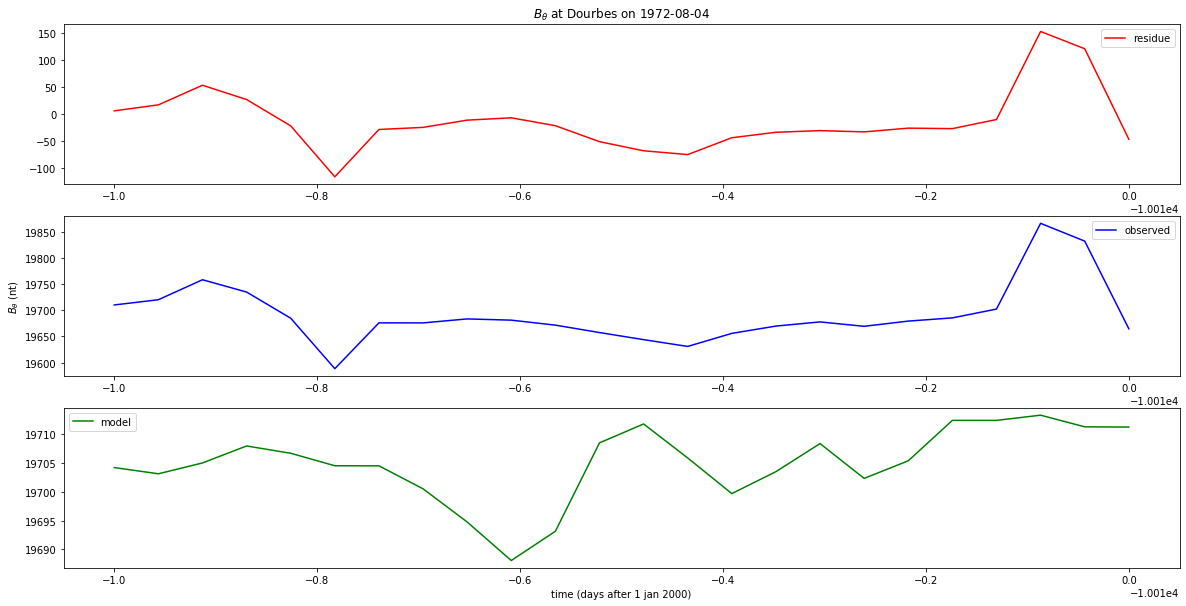

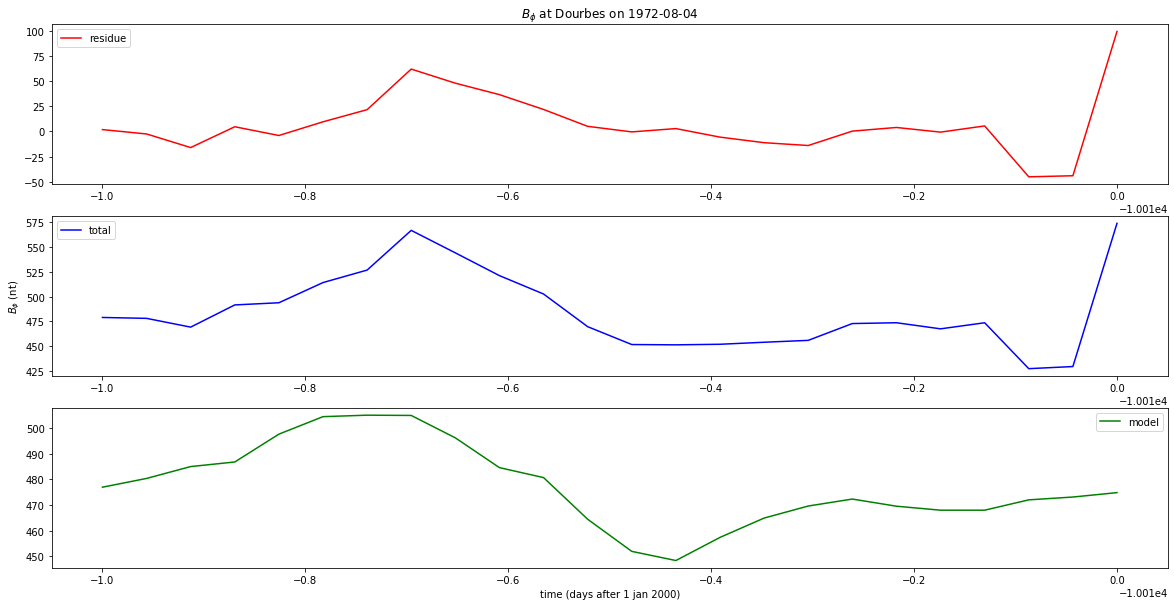

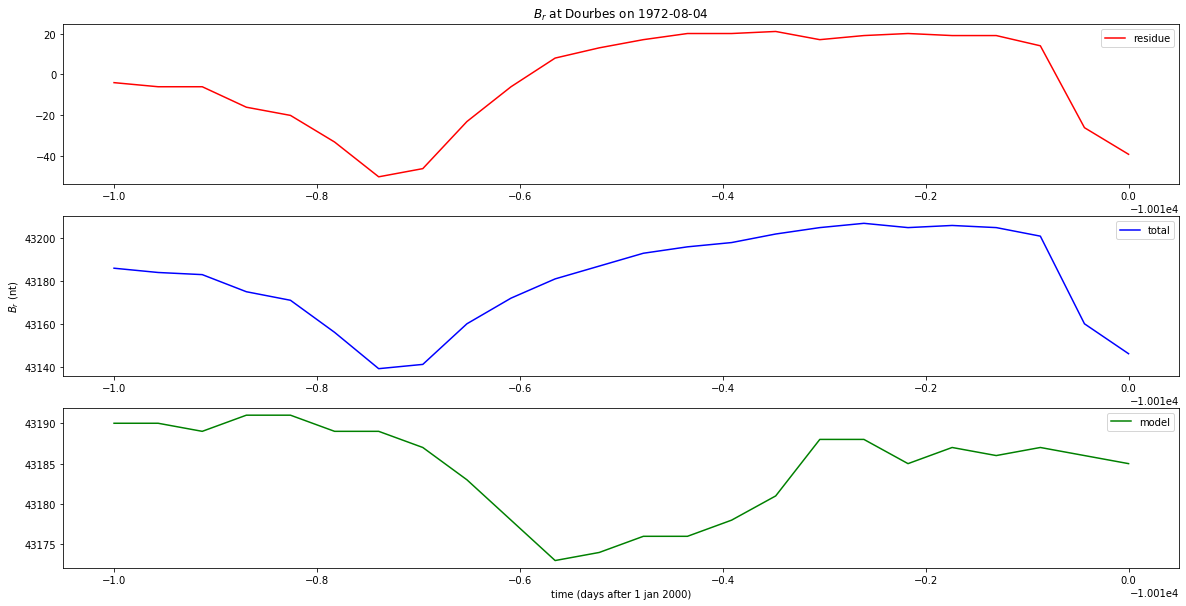

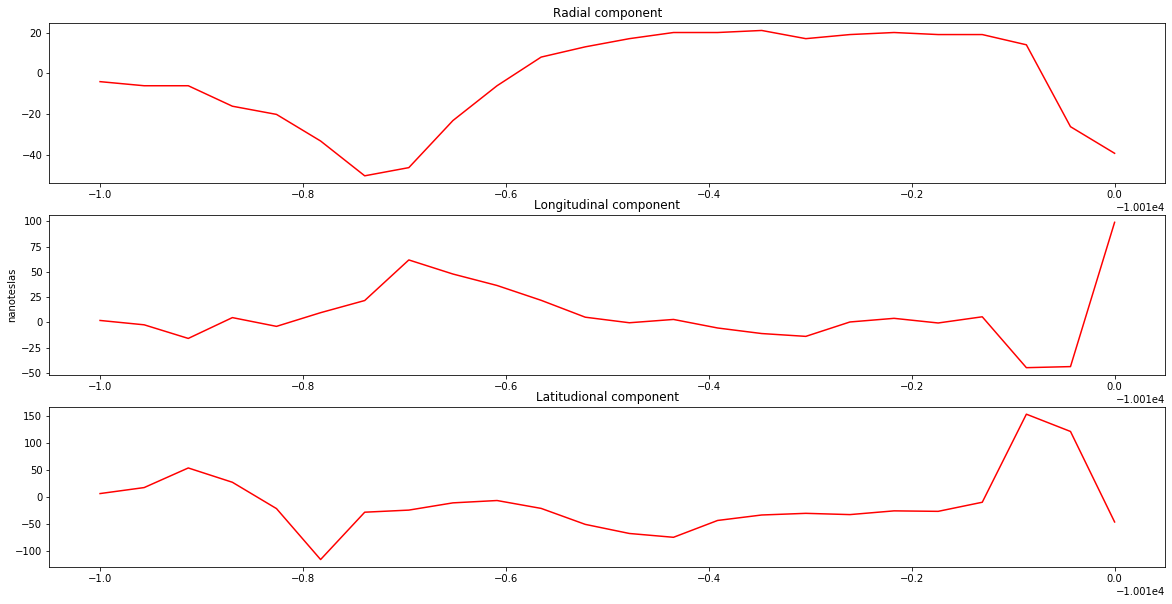

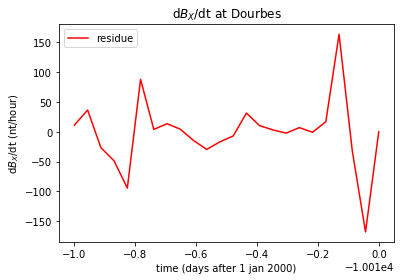

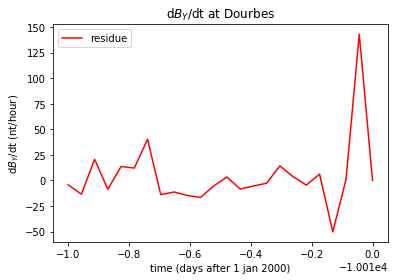

In [63]:
newplotspace('magnetic_data/4-8-1972/dou1972dhor.hor','magnetic_data/3-8-1972/dou1972dhor.hor',14,False,True)

In [3]:
def mag_interpolate(loc,val,latlon,delta):
    import numpy as np
    from pySECS import SECS
    if loc.shape[-1] != 3:
        raise ValueError("Observation locations must have 3 columns (lat, lon, r)")
    if val.shape[-1] != 3:
        raise ValueError("Observed values must have 3 columns (Bx(theta), By(phi), Bz(r))")
    if latlon.shape[-1] != 4:
        raise ValueError("Observed values must have 1 row and 4 columns (latmin, latmax, lonmin, lonmax)")
    RE=6371e3
    
    latlon[1]+=delta
    latlon[3]+=delta
    
    lats = np.arange(latlon[0], latlon[1], delta)
    lons = np.arange(latlon[2], latlon[3], delta)

    nlat = len(lats)
    nlon = len(lons)

    xx, yy = np.meshgrid(lons, lats) #make nice mesh

    sec_loc=np.zeros((nlat*nlon,3))
    for i in range(nlat*nlon): #add poles to sec_loc
        sec_loc[i,:]=[yy.item(i),xx.item(i),RE+110e3] #system is 110 km above ground with multiple poles

    system_df = SECS(sec_df_loc=sec_loc) #initiate new divergence free system using poles (only df free, see paper)
    
    system_df.fit(loc,val) #fit currents to values
    
################## The prediction/interpolation begins ################
#     predlats = np.arange(49, 54.04, 0.05) #Netherlands+Belgium&Germany
#     predlons = np.arange(3.3, 9.64, 0.05)
#     predlatseng = np.arange(51.4, 52.04, 0.05) #seacable england
#     predlonseng = np.arange(0.7, 3.29, 0.05)
#     predlatsnor = np.arange(54.05, 58.34, 0.05) #seacable norway
#     predlonsnor = np.arange(6.1, 6.94, 0.05)

#     nrpoint=len(predlats)*len(predlons)+len(predlatseng)*len(predlonseng)+len(predlatsnor)*len(predlonsnor)

#     predxx1, predyy1 = np.meshgrid(predlons, predlats) #make nice mesh
#     predxx2, predyy2 = np.meshgrid(predlonseng, predlatseng)
#     predxx3, predyy3 = np.meshgrid(predlonsnor, predlatsnor)
#     predxx=np.concatenate((predxx1.flatten(),predxx2.flatten(),predxx3.flatten()))
#     predyy=np.concatenate((predyy1.flatten(),predyy2.flatten(),predyy3.flatten()))
    nrpoint=1
    predyy=np.array([52.813])
    predxx=np.array([6.668])
    pred_loc=np.zeros((nrpoint,3))
    for i in range(nrpoint): #add locations
        pred_loc[i,:]=[predyy.item(i),predxx.item(i),RE] #system is at ground
    
    prediction=system_df.predict(pred_loc, False)
    result=np.zeros((nrpoint,4))
    for i in range(nrpoint):
        result[i,:]=[predyy.item(i),predxx.item(i),prediction[0],prediction[1]]
    return result

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RE=6371000
path='/usr/people/out/Documents/Magnetic_field/'
day='4-8-1972'
day2='4-8-1972_noWitteveen'
resultx=np.zeros(24)
resulty=np.zeros(24)
resultx1=np.zeros(24)
resulty1=np.zeros(24)
resultx2=np.zeros(24)
resulty2=np.zeros(24)
resultx3=np.zeros(24)
resulty3=np.zeros(24)
# resultxg=np.zeros(24)
# resultyg=np.zeros(24)
# resultxg1=np.zeros(24)
# resultyg1=np.zeros(24)
# resultxg2=np.zeros(24)
# resultyg2=np.zeros(24)
# resultxg3=np.zeros(24)
# resultyg3=np.zeros(24)

string=os.listdir(f'{path}magnetic_data/{day2}')
string=sorted(string) #sort alphabetically, otherwise problems later
print(string)
location=np.zeros((len(string),3))
location[:,2]=RE
for counter1,item in enumerate(string):
    File=open(f'{path}magnetic_data/{day2}/{item}','r')
    for counter2,line in enumerate(File):
        if counter2==4:
            word=line.split()
            location[counter1,0]=word[2] #latitude
        if counter2==5:
            word=line.split()
            location[counter1,1]=word[2] #longitude
            break
    File.close()

os.system(f'ls -d /nobackup/users/out/Magnetic_field/4-8-1972_noWitteveen/*1972-08-04 > temp.txt') 
f=open('temp.txt')
string=[]
for item in f:
    item=item.strip('\n')
    string.append(item)
string=sorted(string) #sort alphabetically, otherwise problems now
print(string)
values=np.zeros((len(string),3))
os.system('rm temp.txt')
for counter3 in range(24): #hours per day
    for counter1,item in enumerate(string):
        File=open(f'{item}/allresults.csv')
        for counter2,line in enumerate(File):
            if counter2==counter3+1:
                word=line.split(';')
                values[counter1,:]=[word[0],word[1],word[2]]
                break
        File.close()
        
    result=mag_interpolate(location,values,np.array([43,63,-13,20]),0.5)
    result1=mag_interpolate(location,values,np.array([43,63,-13,20]),0.25)
    result2=mag_interpolate(location,values,np.array([43,63,-13,20]),1)
    result3=mag_interpolate(location,values,np.array([43,63,-13,20]),2)
#     resultg=mag_interpolate(location,values,np.array([42.75,63.25,-13.25,20.25]),0.5)
#     resultg1=mag_interpolate(location,values,np.array([42.825,63.125,-13.125,20.125]),0.25)
#     resultg2=mag_interpolate(location,values,np.array([42.5,63.5,-13.5,20.5]),1)
#     resultg3=mag_interpolate(location,values,np.array([42,64,-14,21]),2)
    
    resultx[counter3]=result[0,2]
    resulty[counter3]=result[0,3]
    resultx1[counter3]=result1[0,2]
    resulty1[counter3]=result1[0,3]
    resultx2[counter3]=result2[0,2]
    resulty2[counter3]=result2[0,3]
    resultx3[counter3]=result3[0,2]
    resulty3[counter3]=result3[0,3]
#     resultxg[counter3]=resultg[0,2]
#     resultyg[counter3]=resultg[0,3]
#     resultxg1[counter3]=resultg1[0,2]
#     resultyg1[counter3]=resultg1[0,3]
#     resultxg2[counter3]=resultg2[0,2]
#     resultyg2[counter3]=resultg2[0,3]
#     resultxg3[counter3]=resultg3[0,2]
#     resultyg3[counter3]=resultg3[0,3]

['dou1972dhor.hor', 'esk1972dhor.hor', 'fur1972dhor.hor', 'had1972dhor.hor', 'ngk1972dhor.hor', 'wng1972dhor.hor']
['/nobackup/users/out/Magnetic_field/4-8-1972_noWitteveen/Dourbes_1972-08-04', '/nobackup/users/out/Magnetic_field/4-8-1972_noWitteveen/Eskdalemuir_1972-08-04', '/nobackup/users/out/Magnetic_field/4-8-1972_noWitteveen/Furstenfeldbruck_1972-08-04', '/nobackup/users/out/Magnetic_field/4-8-1972_noWitteveen/Hartland_1972-08-04', '/nobackup/users/out/Magnetic_field/4-8-1972_noWitteveen/Niemegk_1972-08-04', '/nobackup/users/out/Magnetic_field/4-8-1972_noWitteveen/Wingst_1972-08-04']


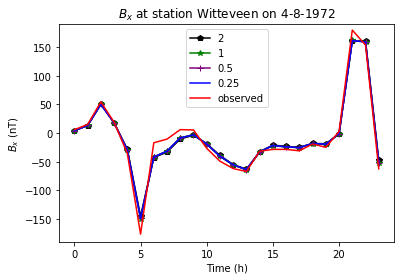

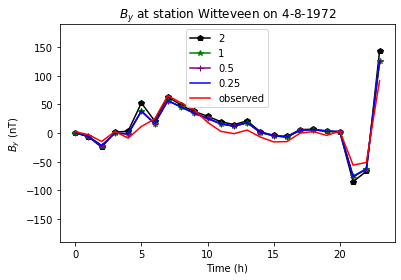

In [16]:
File=open(f'/nobackup/users/out/Magnetic_field/4-8-1972/Witteveen_1972-08-04/allresults.csv')
obsx=np.zeros(24)
obsy=np.zeros(24)
for counter,line in enumerate(File):
    if counter>0:
        word=line.split(';')
        obsx[counter-1]=word[0]
        obsy[counter-1]=word[1]
File.close()

plt.rcParams.update({'font.size': 10})

time=np.arange(0,24,1)
figx=plt.figure()
ax=figx.add_subplot()
ax.plot(time,resultx3,label='2',color='black',marker="p")
ax.plot(time,resultx2,label='1',color='green',marker="*")
ax.plot(time,resultx,label='0.5',color='purple',marker="+")
ax.plot(time,resultx1,label='0.25',color='blue')
# ax.plot(time,resultxg,label='0.5 shifted',color='blue')
# ax.plot(time,resultxg1,label='0.25 shifted',color='purple')
# ax.plot(time,resultxg2,label='1 shifted',color='green')
# ax.plot(time,resultxg3,label='2 shifted',color='black')
ax.plot(time,obsx,label='observed',color='red')
ax.legend(loc='upper center')
ax.set_xlabel('Time (h)')
ax.set_ylabel('$B_x$ (nT)')
ax.set_ylim(-190,190)
ax.set_title('$B_x$ at station Witteveen on 4-8-1972')
plt.savefig(f'{path}station_results/Witteveen_Bx.png')

figy=plt.figure()
ax=figy.add_subplot()
ax.plot(time,resulty3,label='2',color='black',marker="p")
ax.plot(time,resulty2,label='1',color='green',marker="*")
ax.plot(time,resulty,label='0.5',color='purple',marker="+")
ax.plot(time,resulty1,label='0.25',color='blue')
ax.plot(time,obsy,label='observed',color='red')
ax.legend(loc='upper center')
ax.set_xlabel('Time (h)')
ax.set_ylabel('$B_y$ (nT)')
ax.set_ylim(-190,190)
ax.set_title('$B_y$ at station Witteveen on 4-8-1972')
plt.savefig(f'{path}station_results/Witteveen_By.png')

In [2]:
###################### Start functions ##########################
def magnetic_time(q,stepmin,stepmax,path,day,location,string):
    def mag_interpolate(loc,val,latlon,delta):
        if loc.shape[-1] != 3:
            raise ValueError("Observation locations must have 3 columns (lat, lon, r)")
        if val.shape[-1] != 3:
            raise ValueError("Observed values must have 3 columns (Bx(theta), By(phi), Bz(r))")
        if latlon.shape[-1] != 4:
            raise ValueError("Observed values must have 1 row and 4 columns (latmin, latmax, lonmin, lonmax)")
        RE=6371e3

        latlon[1]+=delta
        latlon[3]+=delta

        lats = np.arange(latlon[0], latlon[1], delta)
        lons = np.arange(latlon[2], latlon[3], delta)

        nlat = len(lats)
        nlon = len(lons)

        xx, yy = np.meshgrid(lons, lats) #make nice mesh

        sec_loc=np.zeros((nlat*nlon,3))
        for i in range(nlat*nlon): #add poles to sec_loc
            sec_loc[i,:]=[yy.item(i),xx.item(i),RE+110e3] #system is 110 km above ground with multiple poles

        system_df = SECS(sec_df_loc=sec_loc) #initiate new divergence free system using poles (only df free, see paper)

        system_df.fit(loc,val) #fit currents to values

    ################## The prediction/interpolation begins ################
        predlats = np.arange(49, 54.04, 0.05) #Netherlands+Belgium&Germany
        predlons = np.arange(3.3, 9.64, 0.05)
        predlatseng = np.arange(51.4, 52.04, 0.05) #seacable england
        predlonseng = np.arange(0.7, 3.29, 0.05)
        predlatsnor = np.arange(54.05, 58.34, 0.05) #seacable norway
        predlonsnor = np.arange(6.1, 6.94, 0.05)

        nrpoint=len(predlats)*len(predlons)+len(predlatseng)*len(predlonseng)+len(predlatsnor)*len(predlonsnor)

        predxx1, predyy1 = np.meshgrid(predlons, predlats) #make nice mesh
        predxx2, predyy2 = np.meshgrid(predlonseng, predlatseng)
        predxx3, predyy3 = np.meshgrid(predlonsnor, predlatsnor)
        predxx=np.concatenate((predxx1.flatten(),predxx2.flatten(),predxx3.flatten()))
        predyy=np.concatenate((predyy1.flatten(),predyy2.flatten(),predyy3.flatten()))
    #     nrpoint=1
    #     predyy=np.array([50.1])
    #     predxx=np.array([4.599])
        pred_loc=np.zeros((nrpoint,3))
        for i in range(nrpoint): #add locations
            pred_loc[i,:]=[predyy.item(i),predxx.item(i),RE] #system is at ground

        prediction=system_df.predict(pred_loc, False)
        result=np.zeros((nrpoint,4))
        for i in range(nrpoint):
            result[i,:]=[predyy.item(i),predxx.item(i),prediction[i,0],prediction[i,1]]
        return result
################ starts superior function #####################
    logging.info(f'Thread {q} is running, starting at {stepmin}.')
    for counter3 in range(stepmin,stepmax): #minutes per day
        values=np.zeros((len(string),3))
        with lock:
            logging.info(f'Thread {q} got a lock')
            for counter1,item in enumerate(string):
                File=open(f'{path}station_results/{day}/{item}/allresults.csv')
                for counter2,line in enumerate(File):
                    if counter2==(counter3+1):
                        word=line.split(';')
                        values[counter1,:]=[word[0],word[1],word[2]]
                        break
                File.close()
                
            result=mag_interpolate(location,values,np.array([43,63,-13,20]),0.5)
        logging.info(f'Thread {q} released lock and finished interpolating for step {counter3}.')
#         time.sleep(0.01)
        localvar.newfile1=pd.DataFrame(columns=['lat','lon','Bx'])
        localvar.newfile2=pd.DataFrame(columns=['lat','lon','By'])
        logging.info(f'Thread {q} is busy writing to file.')
        for i in range(len(result)):
            localvar.newfile1.loc[i]=result[i,1], result[i,0], result[i,2]
            localvar.newfile2.loc[i]=result[i,1], result[i,0], result[i,3]
        logging.info(f'Thread {q} is searching.')
        if counter3<10:
            localvar.newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_000{counter3}.csv', sep=' ', index=False, header=False)
            localvar.newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_000{counter3}.csv.Y', sep=' ', index=False, header=False)
        elif counter3<100 and counter3>9:
            localvar.newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_00{counter3}.csv', sep=' ', index=False, header=False)
            localvar.newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_00{counter3}.csv.Y', sep=' ', index=False, header=False)
        elif counter3<1000 and counter3>99:
            localvar.newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_0{counter3}.csv', sep=' ', index=False, header=False)
            localvar.newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_0{counter3}.csv.Y', sep=' ', index=False, header=False)
        else:
            localvar.newfile1.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_{counter3}.csv', sep=' ', index=False, header=False)
            localvar.newfile2.to_csv(path_or_buf=f'{path}station_results/{day}/interpolation/minute_{counter3}.csv.Y', sep=' ', index=False, header=False)
        logging.info(f'Thread {q} has found.')
    logging.warning(f'Thread {q} has finished.')
############################# End of superior function ##########################    

In [71]:
# make plot of interpolation without witteveen
import os
import re
import logging
# import time
import pandas as pd
import numpy as np
import threading
from multiprocessing import Process
from multiprocessing import Lock
# import concurrent.futures
from pySECS import SECS   
# lock=threading.Lock()
localvar=threading.local()
lock=Lock()

RE=6371000
path='/usr/people/out/Documents/Magnetic_field/'
day2='4-8-1972_noWitteveen'
day='4-8-1972_noWitteveen'
f= open(f"{path}station_results/logbook.log","w+")
logging.basicConfig(filename=f'{path}station_results/logbook.log', level=logging.DEBUG, format='%(asctime)s %(message)s')

string=os.listdir(f'{path}magnetic_data/{day}')
string=sorted(string) #sort alphabetically, otherwise problems later
logging.debug(f'Used stations are: {string}')
location=np.zeros((len(string),3))
location[:,2]=RE
for counter1,item in enumerate(string):
    File=open(f'{path}magnetic_data/{day}/{item}','r')
    for counter2,line in enumerate(File):
        if counter2==4:
            word=line.split()
            location[counter1,0]=word[2] #latitude
        if counter2==5:
            word=line.split()
            location[counter1,1]=word[2] #longitude
            break
    File.close()

string=[]
stringold=os.listdir(f'{path}station_results/{day2}') 
for line in stringold:
    if re.search(f'1972-08-04',line):
        string.append(line)
string=sorted(string) #sort alphabetically, otherwise problems now
# print(string)
values=np.zeros((len(string),3))
try:
    os.mkdir(f'{path}station_results/{day2}/interpolation')
except:
    logging.warning('Directory is already created, data could be overwritten.')

# magnetic_time(240*0,240*(0+1),path,day,location,string)
n=6
nrsteps=int(24/n)
threads=list()
for index in range(n):
    q=Process(target=magnetic_time, args=(index+1, nrsteps*index, nrsteps*(index+1),path,day2,location,string))
    threads.append(q)
    q.start()
for thread in threads:
    thread.join()
f.close()

In [78]:
import logging
logging.basicConfig(filename='logbookplot.log', level=logging.DEBUG, format='%(asctime)s %(message)s')

from multiprocessing import Process
from multiprocessing import Lock

lock=Lock()
lock2=Lock()

# magnetische contouren latitude
path='/usr/people/out/Documents/Magnetic_field/station_results'
day='4-8-1972_noWitteveen' #real map location
day2="4-8-1972" #what the name should be
proj='-JM15C -P'
lims1='-R0.7/9.6/49/58.3'
lims2='-R3.3/9.6/49/54'

# os.system(f'bash {path}/longitude.sh')
thing=os.listdir(f'{path}/{day}/interpolation')
string=[]
string2=[]
for item in thing:
    if item.endswith(".csv"):
         string.append(item)
    if item.endswith(".csv.Y"):
         string2.append(item)
string=sorted(string)
string2=sorted(string2)

def plottinglatlon(thread,string,string2,start,end):
    for item in string[start:end]:
        with lock:
            item2=item.strip('.csv')
            nr=item2.strip('minute_')
            logging.info(f'Thread {thread} has obtained latlock for step {nr}.')
            os.system(f'gmt xyz2grd {path}/{day}/interpolation/{item} -G{path}/{day}/interpolation/gridlat{nr}.grd -I0.05 -V -N0 {lims1}')
            psfile1=f'{path}/{day}/interpolation/minlat_{nr}.ps'
            os.system(f'gmt pscoast {proj} {lims2} -W0.25p -Ggrey -Slightblue -N1/0.25p -Df -K> {psfile1}' )
            os.system(f'gmt psbasemap {proj} {lims2} -Ba1 -BWeSn+t"Bx at {day2} after {nr} hours" -O -K>> {psfile1}' )
            os.system(f'gmt grdcontour {path}/{day}/interpolation/gridlat{nr}.grd -C1 -A5+f20p {proj} {lims2} -O >>{psfile1}')
            logging.info(f'Thread {thread} has released latlock.')
        os.system(f'convert -density 300 {psfile1} {path}/{day}/interpolation/minlat_{nr}.png')
        os.system(f'rm {psfile1}')
        os.system(f'rm {path}/{day}/interpolation/gridlat{nr}.grd')
        logging.info(f'Thread {thread} has finished plotting lat for step {nr}.')
        
    for item in string2[start:end]:
        with lock2:
            item2=item.strip('.csv.Y')
            nr=item2.strip('minute_')
            logging.info(f'Thread {thread} has obtained lonlock for step {nr}.')
            os.system(f'gmt xyz2grd {path}/{day}/interpolation/{item} -G{path}/{day}/interpolation/gridlon{nr}.grd -I0.05 -V -N0 {lims1}')
            psfile2=f'{path}/{day}/interpolation/minlon_{nr}.ps'
            os.system(f'gmt pscoast {proj} {lims2} -W0.25p -Ggrey -Slightblue -N1/0.25p -Df -K> {psfile2}' )
            os.system(f'gmt psbasemap {proj} {lims2} -Ba1 -BWeSn+t"By at {day2} after {nr} hours" -O -K>> {psfile2}' )
            os.system(f'gmt grdcontour {path}/{day}/interpolation/gridlon{nr}.grd -C1 -A5+f20p {proj} {lims2} -O >>{psfile2}')
            logging.info(f'Thread {thread} has released lonlock.')
        os.system(f'convert -density 300 {psfile2} {path}/{day}/interpolation/minlon_{nr}.png')
        os.system(f'rm {psfile2}')
        os.system(f'rm {path}/{day}/interpolation/gridlon{nr}.grd')
        logging.info(f'Thread {thread} has finished plotting lon for step {nr}.')     
# os.system(f'rm {path}/*.csv.Y')

n=6
nrsteps=int(24/n)
threads=list()
for index in range(n):
    q=Process(target=plottinglatlon, args=(index+1, string, string2, nrsteps*index, nrsteps*(index+1)))
    threads.append(q)
    q.start()
for thread in threads:
    thread.join()
logging.info('Plotting completed!')

In [76]:
import os
path='/usr/people/out/Documents/Magnetic_field/station_results/4-8-1972/interpolation'
os.system(f'ffmpeg -framerate 2 -pattern_type glob -i "{path}/minlat_????.png" {path}/outputlat.mp4')
os.system(f'ffmpeg -framerate 2 -pattern_type glob -i "{path}/minlon_????.png" {path}/outputlon.mp4')

0

In [33]:
# plot magnetic signal for Witteveen Halloween
import numpy as np
import os

path='/nobackup/users/out/Magnetic_field/min_17-03-2015_2'
os.system(f'ls {path}/interpolation > {path}/temp.txt')
File=open(f'{path}/temp.txt')
string=[]
Bx=np.zeros(1440)
By=np.zeros(1440)
Bxt=np.zeros(1440)
Byt=np.zeros(1440)

for item in File:
    item=item.strip('\n')
    string.append(item)
File.close()
string=sorted(string)

for counter,item in enumerate(string):
    data=open(f'{path}/interpolation/{item}')
    for counter2,line in enumerate(data):
        if counter2==6232:#9719:
            words=line.split(' ')
            if counter%2==0:
                Bx[int(counter/2)]=words[2]
            else:
                By[int(counter/2)]=words[2]
            break
    data.close()
for item in range(len(Bx)-1):
    Bxt[item]=Bx[item+1]-Bx[item]
    Byt[item]=By[item+1]-By[item]

[]

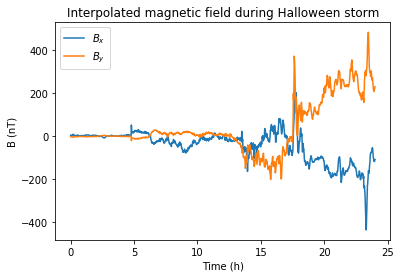

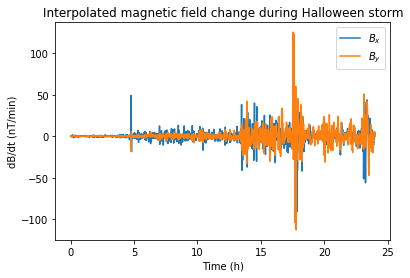

In [34]:
import matplotlib.pyplot as plt
import numpy as np

timevector=np.linspace(0,24,1440)
fig=plt.figure()
ax=fig.add_subplot()
ax.set_title('Interpolated magnetic field during Halloween storm')
ax.set_ylabel('B (nT)')
ax.set_xlabel('Time (h)')
ax.plot(timevector, Bx, label='$B_x$')
ax.plot(timevector, By, label='$B_y$')
ax.legend()
plt.plot()
#plt.savefig(f'{path}/Witteveenmag.png')

fig2=plt.figure()
ax1=fig2.add_subplot()
ax1.set_title('Interpolated magnetic field change during Halloween storm')
ax1.set_ylabel('dB/dt (nT/min)')
ax1.set_xlabel('Time (h)')
ax1.plot(timevector, Bxt, label='$B_x$')
ax1.plot(timevector, Byt, label='$B_y$')
ax1.legend()
plt.plot()
#plt.savefig(f'{path}/Witteveenmagdt.png')

In [2]:
# plot electric signal for Witteveen Halloween
import numpy as np
import os

path='/nobackup/users/out/Magnetic_field/min_17-03-2015_2'
os.system(f'ls {path}/electric_field_north > {path}/tempx.txt')
os.system(f'ls {path}/electric_field_east > {path}/tempy.txt')
Filex=open(f'{path}/tempx.txt')

stringx=[]
stringy=[]
Ex6=np.zeros(1440)
Ey6=np.zeros(1440)

for item in Filex:
    item=item.strip('\n')
    stringx.append(item)

stringx=sorted(stringx)

Filey=open(f'{path}/tempy.txt')
for item in Filey:
    item=item.strip('\n')
    stringy.append(item)

stringy=sorted(stringy)

for counter,item in enumerate(stringx):
    data=open(f'{path}/electric_field_north/{item}')
    for counter2,line in enumerate(data):
        if counter2==0:
            words=line.split(' ')
            Ex6[counter]=words[2]
            break
for counter,item in enumerate(stringy):
    data=open(f'{path}/electric_field_east/{item}')
    for counter2,line in enumerate(data):
        if counter2==0:
            words=line.split(' ')
            Ey6[counter]=words[2]
            break
os.system(f'rm {path}/tempx.txt')
os.system(f'rm {path}/tempy.txt')

0

[]

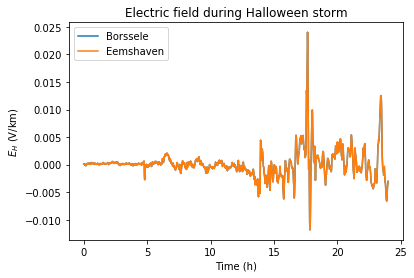

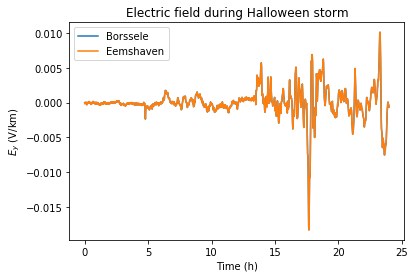

In [5]:
import matplotlib.pyplot as plt
import numpy as np
path='/nobackup/users/out/Magnetic_field/Halloween'

timevector=np.linspace(0,24,1440)
fig=plt.figure()
ax=fig.add_subplot()
ax.set_title('Electric field during Halloween storm')
ax.set_ylabel('$E_H$ (V/km)')
ax.set_xlabel('Time (h)')

ax.plot(timevector, Ex5*1000, label='Borssele')
ax.plot(timevector, Ex6*1000, label='Eemshaven')
# ax.plot(timevector, np.sqrt(Ex7**2+Ey7**2)*1000, label='Witteveen')
# ax.plot(timevector, Ex0*1000, label='Eemshaven other')
# ax.plot(timevector, Ex1*1000, label='Eur')
ax.legend()
# ax.set_ylim(-0.085,0.08)
plt.plot()
# plt.savefig(f'{path}/WitteveenelecN.pdf')

fig=plt.figure()
ax=fig.add_subplot()
ax.set_title('Electric field during Halloween storm')
ax.set_ylabel('$E_y$ (V/km)')
ax.set_xlabel('Time (h)')
ax.plot(timevector, Ey5*1000, label='Borssele')
ax.plot(timevector, Ey6*1000, label='Eemshaven')
# ax.plot(timevector, Ey7*1000, label='Borssele other')
# ax.plot(timevector, Ey0*1000, label='Eemshaven other')
# ax.plot(timevector, Ey1*1000, label='Eur')
ax.legend()
# ax.set_ylim(-0.085,0.08)
plt.plot()
# plt.savefig(f'{path}/WitteveenelecE.png')

In [8]:
print(Ey1)

[ 1.01598107e-07 -1.28624285e-07 -2.22979654e-07 ... -5.40028062e-07
 -7.06300038e-07 -6.84022935e-07]
